## TODO
- NN.forward -- make use of the parameter limit
- write the backprob loop
- write gradient check
- save the model
- and then start testing models

In [1]:
import seaborn as sb
import numpy as np
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

/home/chahuja/env/tf/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Load Data
train = np.genfromtxt('digitstrain.txt', delimiter=',')
test = np.genfromtxt('digitstest.txt', delimiter=',')
val = np.genfromtxt('digitsvalid.txt', delimiter=',')

## Plotting Image of a training input

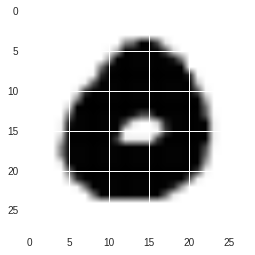

In [3]:
# Plotting the image
plt.imshow(train[0,:-1].reshape((28,28)))
## The image is squeezed row-wise

## Class description
```sh
graph - [num_nodes(int), num_nodes(int), ...]
each layer ends with sigmoid
graph ends with softmax and crossentropy loss
```

In [11]:
# Basic loss/activation functions and their gradients which are codenamed "inv"
# These functions are defined with input as numpy.matrix format.
# things may go haywire if numpy.array is used 
# even though numpy.matrix inherits properties from numpy.array
def cross_entropy_loss(vec, gt):
  return -gt*np.log(vec)
  
def sigmoid(mat):
  return 1./(1+ np.exp(-mat))

def inv_sigmoid(mat):
  return sigmoid(mat)*(1-sigmoid(mat))

def softmax(vec):
  return np.concatenate(
    tuple([np.exp(vec[i,:])*1./np.exp(vec[i,:]).sum() for i in range(vec.shape[0])])
    , axis = 0)

def inv_softmax_with_loss(vec, gt):
  # gt - ground truth in one hot vector format
  if (vec.shape != gt.shape):
    raise Exception("Prediction and Expected Values must have the same dimensions")
    
  return softmax(vec) - gt

In [15]:
class NN(object):
  def __init__(self,graph):
    self.graph = graph
    self.weights = list()
    
    prev_dim = -1
    for dim in self.graph:
        if (prev_dim > 0):
          # set the high and low bounds for the random initialization 
          # based on xxx rule
          high = np.sqrt(6.0/(prev_dim + dim))
          low = -high
          # prev_dim + 1 to include a row for bias 
          self.weights.append(np.random.uniform(low=low,high=high,size=(prev_dim+1,dim)))
        prev_dim = dim

  def forward(self,X,limit = 0):
    # add a column of ones to take care of the bias
    X = np.concatenate((X,np.expand_dims(np.ones_like(X[:,0]),axis=1)), axis = 1)
    X = np.mat(X)
    # Converting input to matrix form
    for k in range(len(self.weights)):
      X = sigmoid(X*np.mat(self.weights[k]))
      X = np.concatenate((X,np.ones_like(X[:,0])), axis = 1)
    # Remocing the extra layer of ones before softmax
    X = X[:,:-1]
    return softmax(X)

In [26]:
model = NN([784,100,50,10])

In [27]:
model.forward(train[0:10,:-1])

matrix([[ 0.10223401,  0.10233019,  0.09950957,  0.08852853,  0.12924227,
          0.0952147 ,  0.10091445,  0.11205681,  0.08276132,  0.08720814],
        [ 0.10083396,  0.10302782,  0.09896994,  0.08727803,  0.13034849,
          0.09669254,  0.10108763,  0.11195318,  0.08264818,  0.08716022],
        [ 0.10152268,  0.10347071,  0.10012688,  0.08872316,  0.12948407,
          0.09515305,  0.10059478,  0.11186583,  0.08178945,  0.0872694 ],
        [ 0.10212329,  0.10363466,  0.09942094,  0.0893854 ,  0.12972654,
          0.09550172,  0.09956213,  0.1113978 ,  0.08198398,  0.08726355],
        [ 0.10201509,  0.10191971,  0.09915075,  0.0884678 ,  0.12954011,
          0.09539018,  0.09998106,  0.11253233,  0.08354204,  0.08746094],
        [ 0.10138953,  0.10377468,  0.10077369,  0.08809848,  0.12936178,
          0.09543373,  0.09929695,  0.11234656,  0.08229371,  0.08723089],
        [ 0.10183341,  0.10149552,  0.09941767,  0.08819725,  0.12957439,
          0.09582462,  0.1014344

In [28]:
print([model.weights[i].shape for i in range(len(model.weights))])

[(785, 100), (101, 50), (51, 10)]


In [29]:
model.weights

[array([[ 0.05062882, -0.01128045, -0.07493496, ...,  0.03855577,
          0.0466856 , -0.01098065],
        [ 0.0143812 , -0.07012097,  0.0739023 , ..., -0.06418279,
         -0.06910257, -0.06244531],
        [ 0.07475649,  0.04736721, -0.01228276, ..., -0.07270235,
          0.07085008,  0.03175375],
        ..., 
        [ 0.07296445, -0.06371534, -0.01142357, ..., -0.05090986,
          0.04881721, -0.04563758],
        [-0.06939505,  0.07314833,  0.06536761, ..., -0.05791099,
         -0.0102137 ,  0.02418136],
        [ 0.06546591,  0.05707079, -0.07452245, ...,  0.02735108,
         -0.0349033 ,  0.07552443]]),
 array([[ 0.00880096,  0.14148106, -0.09305398, ..., -0.10546009,
          0.15082468, -0.14630054],
        [ 0.08112002, -0.1087789 , -0.14479756, ..., -0.13298132,
          0.19612121,  0.11460456],
        [ 0.15367907,  0.14387722,  0.15639447, ...,  0.0529379 ,
          0.16677141,  0.04264093],
        ..., 
        [-0.05637912, -0.11857283, -0.15560352, ...,

In [9]:
a = np.array([[1, 2], [3, 4], [10,11]])
b = np.array([[5, 6,7]]).T
b = np.ones_like(a[:,0])
b = np.expand_dims(b,axis=1)
a.shape
b.shape

(3, 1)

In [10]:
a.sum()

31

In [ ]:
np.concatenate((a, b), axis=1)

In [ ]:
a = np.matrix([np.array([1,2]),np.array([3,4])])

In [ ]:
a
